## ASTR496: Foundations of Data Science in Astronomy
Gautham Narayan
gsn@illinois.edu

### Midterm

In [97]:
# Q1: Maximum Likelihood Estimation for Stellar Parameters
# Estimating Temperature and Extinction from Multi-band Photometry

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from scipy.stats import norm
import emcee
from chainconsumer import Chain, ChainConsumer
import pandas as pd
from matplotlib import cm
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

#### **Problem Setup:**
#### - We observe a star in multiple photometric bands (B, V, R, I, J, H, K)
#### - We want to estimate: stellar temperature T and visual extinction A_V
#### - We assume we know the distance from e.g. Gaia (or fit for it separately)
####
#### **Model:**
#### For each filter λ, the observed magnitude is:
####
#### m_λ = M_λ(T) + 5*log₁₀(d/10) + A_V * R_λ
####
#### where:
#### - M_λ(T) = absolute magnitude in filter λ for temperature T
#### - d = distance in parsecs
#### - A_V = visual extinction
#### - R_λ = extinction coefficient for filter λ

### First, I have to give you a stellar model as a function of wavelength
### We'll use a Planck function i.e. a blackbody

In [98]:
def planck_function(wavelength, temperature):
    """
    Planck function for blackbody radiation
    wavelength in microns, temperature in Kelvin
    Returns relative flux (arbitrary units)
    """
    h = 6.626e-34  # Planck constant
    c = 3e8        # Speed of light
    k = 1.381e-23  # Boltzmann constant

    wl_m = wavelength * 1e-6  # Convert to meters

    # Planck function
    numerator = 2 * h * c**2
    denominator = wl_m**5 * (np.exp(h * c / (wl_m * k * temperature)) - 1)

    return numerator / denominator

### Next we need to define a photometric system - we'll use the Johnson(-Morgan) Kron-Cousins UBVRI filters and the reddening coefficients 
### and JHK for the IR, largely because you can look up the filter's effective wavelengths $\lambda_\text{eff}$ in microns and the reddening coefficients from something like Cardelli-Clayton-Mathis '89.

In [99]:
filters = {
    'B': {'lambda_eff': 0.44, 'R_lambda': 4.1},   # Blue
    'V': {'lambda_eff': 0.55, 'R_lambda': 3.1},   # Visual (reference)
    'R': {'lambda_eff': 0.64, 'R_lambda': 2.7},   # Red
    'I': {'lambda_eff': 0.79, 'R_lambda': 2.0},   # Near-IR
    'J': {'lambda_eff': 1.25, 'R_lambda': 0.9},   # IR
    'H': {'lambda_eff': 1.63, 'R_lambda': 0.6},   # IR
    'K': {'lambda_eff': 2.19, 'R_lambda': 0.4}    # IR
}

In [100]:
# here are some quick arrays of the filters, wavelengths and reddening coefficients.
filter_names = list(filters.keys())
wavelengths = np.array([filters[f]['lambda_eff'] for f in filter_names])
R_lambda = np.array([filters[f]['R_lambda'] for f in filter_names])

print(f"Photometric filters: {filter_names}")
print(f"Effective wavelengths (μm): {wavelengths}")
print(f"Extinction coefficients R_λ: {R_lambda}")

Photometric filters: ['B', 'V', 'R', 'I', 'J', 'H', 'K']
Effective wavelengths (μm): [0.44 0.55 0.64 0.79 1.25 1.63 2.19]
Extinction coefficients R_λ: [4.1 3.1 2.7 2.  0.9 0.6 0.4]


### Next, we need to reate the magnitudes of a star, given the spectral model 
### While we are using the Planck function as an approximation, we'll tie the fluxes to the obsserved flux of the 
### Sun itself, with $T_\text{eff}= 5778$K, and $M_V = 4.83$ (remember the absolute magnitude is defined for a distance of 10pc).

In [101]:
# Create stellar atmosphere model
def stellar_magnitude(temperature, filter_name, reference_temp=5778):
    """
    Calculate absolute magnitude for a star of given temperature
    Simplified model based on Planck function + calibration
    """
    wl = filters[filter_name]['lambda_eff']

    # Get flux ratio compared to solar temperature
    flux_star = planck_function(wl, temperature)
    flux_sun = planck_function(wl, reference_temp)
    flux_ratio = flux_star / flux_sun

    # Convert to magnitude difference (Sun has M_V = 4.83)
    # Add wavelength-dependent correction for more realism
    solar_magnitude = 4.83 + 0.5 * (wl - 0.55)  # Rough color correction

    magnitude = solar_magnitude - 2.5 * np.log10(flux_ratio)

    return magnitude

### Q1. As a function of temperature (3000-10,000K in 1000K steps) determine the B-V color

In [102]:
### YOUR ANSWER HERE
for i in range(3000, 11000, 1000):
    mag_b = stellar_magnitude(i, 'B')
    mag_v = stellar_magnitude(i, 'V')
    color = mag_b - mag_v
    print(f"B-V Color at {i} K = {color:.3f}")

B-V Color at 3000 K = 1.076
B-V Color at 4000 K = 0.485
B-V Color at 5000 K = 0.133
B-V Color at 6000 K = -0.099
B-V Color at 7000 K = -0.262
B-V Color at 8000 K = -0.381
B-V Color at 9000 K = -0.471
B-V Color at 10000 K = -0.542


### Next, I'll give you the "Truth" and some synthetic stellar data, with the true magnitudes of this star in each band using my `stellar_magnitude` but with the reddening and distance correction applied (you're going to have to do this)

In [103]:
# Generate a test star
TRUE_TEMP = 6500  # K
TRUE_A_V = 0.8    # magnitudes
TRUE_DISTANCE = 100    # parsecs


synthetic_star =  {'B': {'magnitude': 12.379, 'error': 0.02, 'true_magnitude': 12.369},
                   'V': {'magnitude': 11.752, 'error': 0.03, 'true_magnitude': 11.756},
                   'R': {'magnitude': 11.579, 'error': 0.04, 'true_magnitude': 11.553},
                   'I': {'magnitude': 11.225, 'error': 0.05, 'true_magnitude': 11.149},
                   'J': {'magnitude': 10.602, 'error': 0.06, 'true_magnitude': 10.616},
                   'H': {'magnitude': 10.592, 'error': 0.07, 'true_magnitude': 10.609},
                   'K': {'magnitude': 10.888, 'error': 0.08, 'true_magnitude': 10.762}}

### Q2.  
### OK, you know the drill 
### define a function that gives you the model magnitudes of the star given the temperature, extinction and distance
### define the log-likelihood
### Use `scipy.optimize` to get the best fit parameters for this star using maximum likelihood estimation
### Calculate the goodness of fit i.e. reduced chi-squared
### Calculate the Inverse Hessian Matrix and report the simple uncertainties on each parameter
### Which parameters are correlated strongly?

In [104]:
# Initial guess
initial_guess = [5500, 0.5, 75]  # Temperature, A_V, Distance


### YOUR ANSWER HERE
def magnitude_model(temperature, a_v, d, start_idx=0, end_idx=7):
    mags = []
    for name, r_l in zip(filter_names[start_idx:end_idx], R_lambda[start_idx:end_idx]):
        mag = stellar_magnitude(temperature, name) + 5 * np.log10(d/10) + a_v * r_l
        mags.append(mag)
    return np.array(mags)

def neg_log_likelihood(params, mag_obs, mag_err, start_idx=0, end_idx=7):
    mags = magnitude_model(params[0], params[1], params[2], start_idx, end_idx)
    return .5 * np.sum(((mags - mag_obs[start_idx:end_idx])/mag_err[start_idx:end_idx])**2)

mag_obs = np.array([band['magnitude'] for band in synthetic_star.values()])
mag_err = np.array([band['error'] for band in synthetic_star.values()])
min = minimize(neg_log_likelihood, initial_guess, args=(mag_obs, mag_err))
params = min.x
print(f"Estimated Temperature = {params[0]:.3f} K")
print(f"Estimated Extinction = {params[1]:.3f} mag")
print(f"Estimated Distance = {params[2]:.3f} pc")
print(f"Temperature Bias = {params[0] - TRUE_TEMP:.3f} K")
print(f"Extinction Bias = {params[1] - TRUE_A_V:.3f} mag")
print(f"Distance Bias = {params[2] - TRUE_DISTANCE:.3f} pc")

mag_exp = magnitude_model(*params)
reduced_chisq = np.sum(((mag_exp - mag_obs)/mag_err)**2) / (len(mag_obs) - len(params))
print(f"Reduced Chi Squared = {reduced_chisq:.3f}")

inv_hess = min.hess_inv
errors = np.sqrt(np.diag(inv_hess))
print("Inverse Hessian =\n", inv_hess)
print(f"Temperature Error = {errors[0]:.3f} K")
print(f"Extinction Error = {errors[1]:.3f} mag")
print(f"Distance Error = {errors[2]:.3f} pc")

corr = inv_hess / np.outer(errors, errors)
print("Correlation Matrix:\n", corr)
#The correlation of each pair of variables is nearly 1, so they are all highly positively correlated

Estimated Temperature = 7631.906 K
Estimated Extinction = 0.941 mag
Estimated Distance = 111.772 pc
Temperature Bias = 1131.906 K
Extinction Bias = 0.141 mag
Distance Bias = 11.772 pc
Reduced Chi Squared = 0.827
Inverse Hessian =
 [[ 1.08989454e+04  2.64887739e+00 -2.72426830e+02]
 [ 2.64887739e+00  7.54908318e-04 -8.11532252e-02]
 [-2.72426830e+02 -8.11532252e-02  8.95286076e+00]]
Temperature Error = 104.398 K
Extinction Error = 0.027 mag
Distance Error = 2.992 pc
Correlation Matrix:
 [[ 1.          0.92346941 -0.87212096]
 [ 0.92346941  1.         -0.98713776]
 [-0.87212096 -0.98713776  1.        ]]


### Q3.

### It is worth remembering the difference between Monte Carlo and Markov Chain Monte Carlo
### Using the same true parameters provided to you with Q2, generate 1000 random stars with the same true values, but different random seeds
### Repeat your analysis in Q2 for each of these 1000 stars, saving the results
### Use the results from this Monte Carlo process to determine a more robust uncertainty estimate, and measure the mean bias (i.e. how far are you from the truth) in parameter recovery

In [105]:
### YOUR ANSWER HERE
mag_true = np.array([band['true_magnitude'] for band in synthetic_star.values()])
estimates = []
for i in range(1000):
    mags = mag_true + mag_err * np.random.randn(len(mag_true))
    min = minimize(neg_log_likelihood, initial_guess, args=(mags, mag_err))
    estimates.append(min.x)
med = np.median(estimates, axis=0)
std = np.std(estimates, axis=0)
print(f"Estimated Temperature = {med[0]:.3f} K")
print(f"Estimated Extinction = {med[1]:.3f} mag")
print(f"Estimated Distance = {med[2]:.3f} pc")
print(f"Temperature Error = {std[0]:.3f} K")
print(f"Extinction Error = {std[1]:.3f} mag")
print(f"Distance Error = {std[2]:.3f} pc")
print(f"Temperature Bias = {med[0] - TRUE_TEMP:.3f} K")
print(f"Extinction Bias = {med[1] - TRUE_A_V:.3f} mag")
print(f"Distance Bias = {med[2] - TRUE_DISTANCE:.3f} pc")

Estimated Temperature = 6505.387 K
Estimated Extinction = 0.801 mag
Estimated Distance = 99.756 pc
Temperature Error = 1474.081 K
Extinction Error = 0.203 mag
Distance Error = 12.460 pc
Temperature Bias = 5.387 K
Extinction Bias = 0.001 mag
Distance Bias = -0.244 pc


### Q4. 

### Finally, try this problem with a Markov Chain Monte Carlo but this time, incorporating a prior on the distance of 98 +/- 5 pc from synthetic Gaia, but repeating the anaysis three times - once with all filters, next with RIJHK and then with BVRIJ only.

#### Make reasonable choices for the number of walkers, steps, thinning etc. It's your responsibility to ensure the posteriors are well sampled.

### Show corner plots for all three cases in the same figure (you can try the `ChainConsumer` package)

### How do these results compare, and what happens to the extinction and temperature with fewer bands, and in the case of all filters, with your answer from Q2/Q3. 

100%|██████████| 10000/10000 [00:14<00:00, 685.13it/s]


Using All Filters filters:
Estimated Temperature = 6382.961 K
Estimated Extinction = 0.776 mag
Estimated Distance = 100.376 pc
Temperature Error = 502.118 K
Extinction Error = 0.086 mag
Distance Error = 4.375 pc
Temperature Bias = -117.039 K
Extinction Bias = -0.024 mag
Distance Bias = 0.376 pc
Autocorrelation Time = 120.870


100%|██████████| 10000/10000 [00:12<00:00, 799.29it/s]


Using RIJKH filters:
Estimated Temperature = 6301.202 K
Estimated Extinction = 0.776 mag
Estimated Distance = 98.989 pc
Temperature Error = 509.593 K
Extinction Error = 0.091 mag
Distance Error = 4.827 pc
Temperature Bias = -198.798 K
Extinction Bias = -0.024 mag
Distance Bias = -1.011 pc
Autocorrelation Time = 57.921


100%|██████████| 10000/10000 [00:13<00:00, 722.72it/s]


Using BVRIJ filters:
Estimated Temperature = 6458.069 K
Estimated Extinction = 0.792 mag
Estimated Distance = 100.303 pc
Temperature Error = 568.877 K
Extinction Error = 0.099 mag
Distance Error = 4.557 pc
Temperature Bias = -41.931 K
Extinction Bias = -0.008 mag
Distance Bias = 0.303 pc
Autocorrelation Time = 158.486


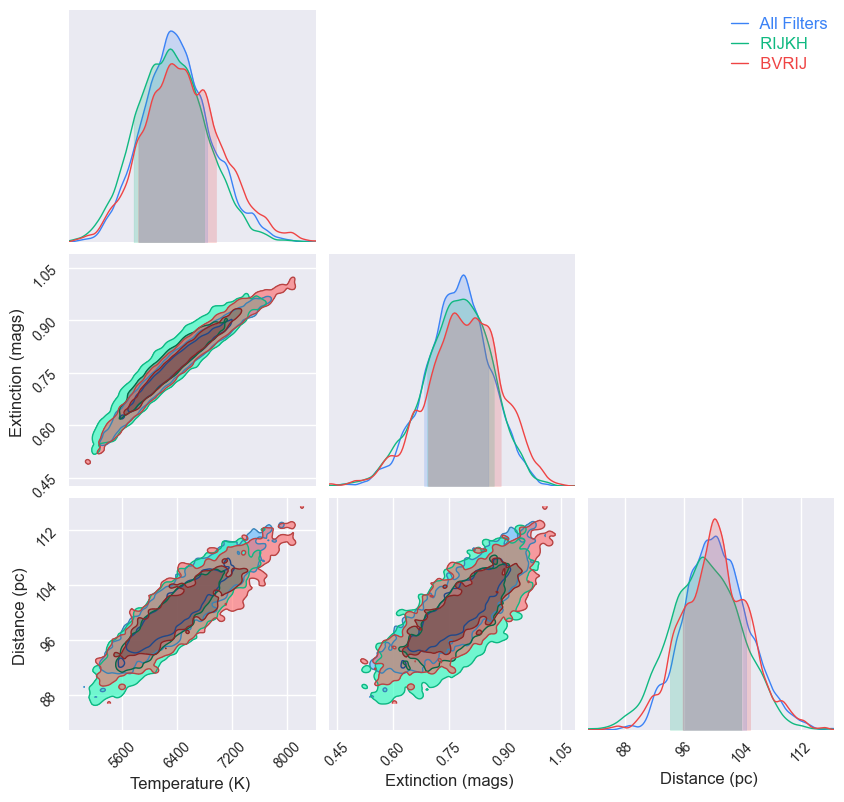

In [106]:
### YOUR ANSWER HERE
#Assuming the above represents a 1-sigma confidence interval
def log_likelihood(params, mag_obs, mag_err, start_idx=0, end_idx=7):
    return -neg_log_likelihood(params, mag_obs, mag_err, start_idx, end_idx)

def log_prior(params):
    return np.log(norm.pdf((params[2] - 98) / 5))

def log_probability(params, mag_obs, mag_err, start_idx=0, end_idx=7):
    return log_prior(params) + log_likelihood(params, mag_obs, mag_err, start_idx, end_idx)

consumer = ChainConsumer()
labels = ["Temperature (K)", "Extinction (mags)", "Distance (pc)"]
bands = [[0, 7, "All Filters"], [2, 7, "RIJKH"], [0, 5, "BVRIJ"]]
for band in bands:
    ndim = 3
    nwalkers = 10
    nsteps = 10000
    guesses = np.array(initial_guess) + np.random.randn(nwalkers, ndim)

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(mag_obs, mag_err, band[0], band[1]))
    sampler.run_mcmc(guesses, nsteps, progress=True)
    auto_correlation = np.median(sampler.get_autocorr_time())
    c = Chain.from_emcee(sampler, labels, band[2], flat=True, thin=int(.5*auto_correlation), discard=int(2*auto_correlation))
    consumer.add_chain(c)
    samples = c.samples
    med = np.median(samples, axis=0)
    std = np.std(samples, axis=0)

    print(f"Using {band[2]} filters:")
    print(f"Estimated Temperature = {med[0]:.3f} K")
    print(f"Estimated Extinction = {med[1]:.3f} mag")
    print(f"Estimated Distance = {med[2]:.3f} pc")
    print(f"Temperature Error = {std[0]:.3f} K")
    print(f"Extinction Error = {std[1]:.3f} mag")
    print(f"Distance Error = {std[2]:.3f} pc")
    print(f"Temperature Bias = {med[0] - TRUE_TEMP:.3f} K")
    print(f"Extinction Bias = {med[1] - TRUE_A_V:.3f} mag")
    print(f"Distance Bias = {med[2] - TRUE_DISTANCE:.3f} pc")
    print(f"Autocorrelation Time = {auto_correlation:.3f}")

fig = consumer.plotter.plot()

#Surprisingly, the BVRIJ filters give the most accurate results for this simulation, while the RIJHK were least accurate. Overall, this is more
#accurate than our analysis of a single star but less accurate than the Monte Carlo simulation. I reckon this is due to my prior, which is not
#centered around d=100pc. Since everything is very highly correlated, this may cause error in the other variables as well.